# Quad Trees

### Import Statements

In [1]:
import enum
import numpy as np
import json as js
import random

import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors

from matplotlib.widgets import Button
from graphviz import Graph

### Visualization

In [2]:
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

        
    def set_axes(self, ax):
        self.ax = ax
        
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

        
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
        
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

            
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [3]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

In [4]:
class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    
    def add_points(self, points):
        self.points = self.points + points

In [5]:
class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
        
    def add(self, line):
        self.lines.append(line)
        
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

In [6]:
class Rect:
    def __init__(self, min_x, max_x, min_y, max_y):
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y

In [7]:
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  

    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

### Utilities

In [8]:
def generateRectangle(numberOfPoints, horizontalInterval, verticalInterval):
    L = []
    
    for i in range(numberOfPoints):
        x = random.uniform(horizontalInterval[0], horizontalInterval[1])
        y = random.uniform(verticalInterval[0], verticalInterval[1])
        L.append((x,y))
        
    return L

In [9]:
def roundPoint(P, places):
    x = 0
    y = 1
    return (round(P[x], places), round(P[y], places))

### Data Structures

In [10]:
class Node():
    def __init__(self, lowerLeft, upperRight, Points=[]):
        self.leaf = True
        self.Points = Points
        self.parent = None
        self.children = [None, None, None, None]
        self.lowerLeft = lowerLeft
        self.upperRight = upperRight
        
    def __iter__(self):
        return QTNodeIterator(self)

In [11]:
class QTNodeIterator():
    def __init__(self, start):
        self._node = start
        self._was_visited = False
        self._children_iterator = [None, None, None, None]
        
        for i in range(4):
            if (start.children[i] != None):
                    self._children_iterator[i] = QTNodeIterator(start.children[i])
                
    def __iter__(self):
        return self
                
    def __next__(self):
        if (not self._was_visited):
            self._was_visited = True
            return self._node
        
        for i in range(4):
            if (self._children_iterator[i] != None):
                try:
                    node = next(self._children_iterator[i])
                    return node
                except:
                    self._children_iterator[i] = None

        raise StopIteration

In [12]:
class QuadTree():
    def __init__(self):
        "
        
        "
        self.root = None
        self._graph = None
        self._plot = None
        
        self._constructionScenes = []
        self._linesToDraw = []
        self._pointsToDraw = []
        self._pointsProcessed = []

    def build(self, Points):
        
            # don't allow to build already built tree
        if (self.root != None or len(Points) == 0):
            return

            # first scene
        self._pointsToDraw = [PointsCollection(Points, color="lightsteelblue")]
        self._constructionScenes.append(Scene(points=self._pointsToDraw))
            
            # find boundaries of given set of points
        lowerLeft, upperRight = self.findBoundaries(Points)
        
            # for only one point normalize boundary
        if (len(Points) == 1):
            lowerLeft  = (lowerLeft[0] - 2, lowerLeft[1] - 2)
            upperRight = (upperRight[0] + 2, upperRight[1] + 2)
            
            # scene of bounding the set of points
        self._linesToDraw = self._rectangle(lowerLeft, upperRight)
        self._constructionScenes.append(Scene(points=self._pointsToDraw,
                                              lines=[LinesCollection(self._linesToDraw.copy(), color="lightgrey")]))
        
        
            # make root and recursively propagete points down the tree
        self.root = Node(lowerLeft, upperRight, Points)
        if (len(Points) > 1):
            self.pointDivision(self.root)    
        
            # make last scene with final state of tree
        self._constructionScenes.append(Scene(points=[PointsCollection(self._pointsProcessed, color="indigo")],
                                              lines=[LinesCollection(self._linesToDraw, color="lightgrey")]))


    def pointDivision(self, node):
        x = 0
        y = 1

        xMid = (node.upperRight[x] + node.lowerLeft[x]) / 2.0
        yMid = (node.upperRight[y] + node.lowerLeft[y]) / 2.0
        
        lines = [[(xMid, node.lowerLeft[y]), (xMid, node.upperRight[y])],
                 [(node.lowerLeft[x], yMid), (node.upperRight[x], yMid)]]
        self._constructionScenes.append(Scene(points=self._pointsToDraw + 
                                                     [PointsCollection(node.Points.copy(), color="darkcyan"),
                                                      PointsCollection(self._pointsProcessed.copy(), color="indigo")],
                                              lines=[LinesCollection(self._linesToDraw.copy(), color="lightgrey")]))
        
        P_NE = list(filter(lambda P : (P[x] >  xMid and P[y] >  yMid), node.Points))
        P_NW = list(filter(lambda P : (P[x] <= xMid and P[y] >  yMid), node.Points))
        P_SE = list(filter(lambda P : (P[x] >  xMid and P[y] <= yMid), node.Points))
        P_SW = list(filter(lambda P : (P[x] <= xMid and P[y] <= yMid), node.Points))

        self._constructionScenes.append(Scene(points=self._pointsToDraw + 
                                                      [PointsCollection(self._pointsProcessed.copy(), color="indigo")],
                                              lines=[LinesCollection(self._linesToDraw.copy(), color="lightgrey"),
                                                     LinesCollection(lines, color="crimson")]))

        self._linesToDraw = self._linesToDraw + lines
        
        node.Points = []
        node.leaf = False

        node.children[0] = Node((xMid, yMid), node.upperRight, P_NE)                          # NE
        node.children[1] = Node((node.lowerLeft[x], yMid), (xMid, node.upperRight[y]), P_NW)  # NW
        node.children[2] = Node((xMid, node.lowerLeft[y]), (node.upperRight[x], yMid), P_SE)  # SE
        node.children[3] = Node(node.lowerLeft, (xMid, yMid), P_SW)                           # SW
        
        for i in range(4):
            node.children[i].parent = node
            if (len(node.children[i].Points) > 1):
                self.pointDivision(node.children[i])
            else:
                self._pointsProcessed = self._pointsProcessed + node.children[i].Points
                if (len(node.children[i].Points) > 0):
                    self._constructionScenes.append(Scene(points=self._pointsToDraw + 
                                                [PointsCollection(node.Points.copy(), color="darkcyan"),
                                                 PointsCollection(self._pointsProcessed.copy(), color="indigo")],
                                                lines=[LinesCollection(self._linesToDraw.copy(), color="lightgrey")]))
                

    def findBoundaries(self, Points):
    
        if (len(Points) == 0):
            return None, None
        x = 0
        y = 1
        smallest = Points[0][x]
        biggest  = Points[0][x]
    
        for P in Points:
            if (P[x] > P[y]):
                if (biggest < P[x]):
                    biggest = P[x]
                if (smallest > P[y]):
                    smallest = P[y]
            else:
                if (biggest < P[y]):
                    biggest = P[y]
                if (smallest > P[x]):
                    smallest = P[x]

        return (smallest, smallest), (biggest, biggest)
        

    def draw_points(self):
        if self._plot != None: 
            self._plot.draw()
        
        else:
            self._plot = Plot(self._constructionScenes)
            self._plot.draw()
            
    def __iter__(self):
        return iter(self.root)
    
    def _rectangle(self, A, C):
        x = 0
        y = 1
        B = (C[x], A[y])
        D = (A[x], C[y])
        return [[A, B], [B, C], [C, D], [D, A]]
    
    def draw_graph(self):
        if self._graph != None:
            display(self._graph)     
        else:
            graph = Graph('QuadTree')
            
            for node in self:
                label = ""
                if (node == self.root):
                    label += "Root\n"
                label += "L: " + str(roundPoint(node.lowerLeft, 2)) + \
                        "\nU: " + str(roundPoint(node.upperRight, 2))
                        
                if (node.leaf == True):
                    label += "\nLeaf"
                    if (len(node.Points) > 0):
                        label += "\nP: " + str(roundPoint(node.Points[0], 2))
                
                graph.node(str(id(node)), label)
                if node.parent != None: graph.edge(str(id(node.parent)), str(id(node)))
                
            self._graph = graph
            display(graph)

### Tests

In [13]:
test1 = generateRectangle(100, [-100, 100], [-100, 100])

<IPython.core.display.Javascript object>


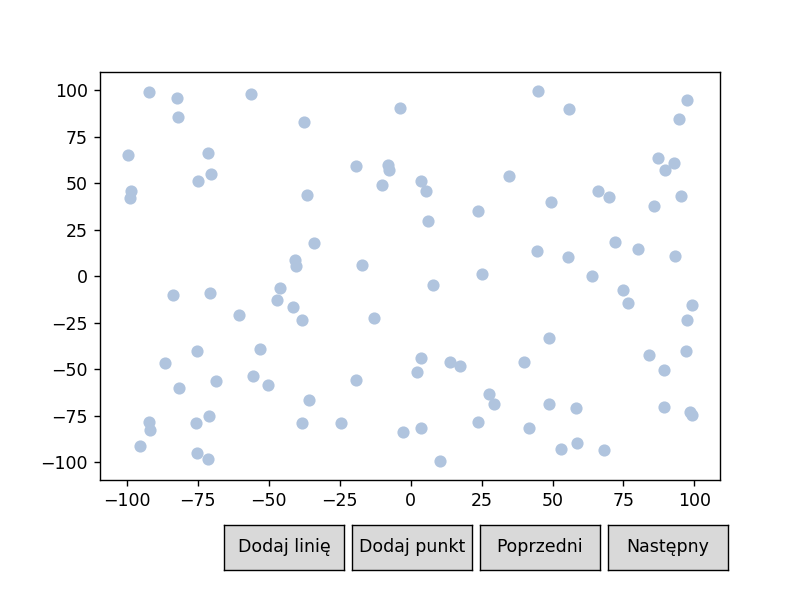

In [14]:
%matplotlib notebook

plot1 = Plot([Scene([PointsCollection(test1, color = 'lightsteelblue')])])
plot1.draw()

<IPython.core.display.Javascript object>


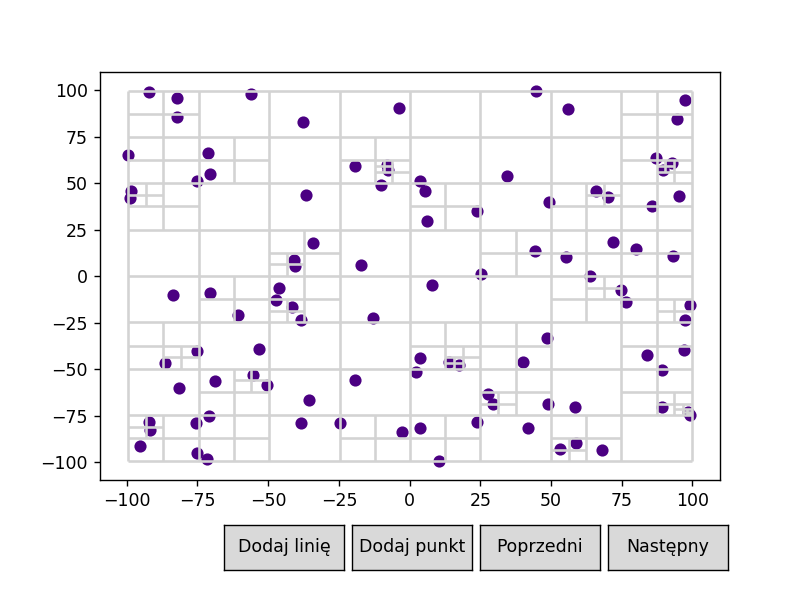

In [15]:
%matplotlib notebook

T = QuadTree()
T.build(test1)
T.draw_points()

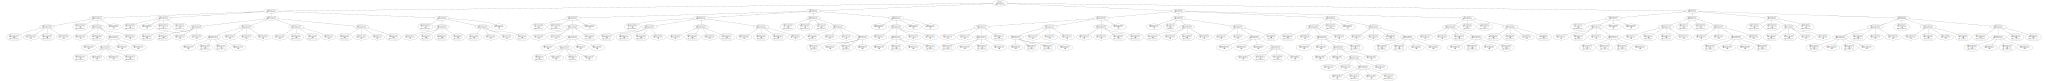

In [16]:
T.draw_graph()